In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# 显示循环的进度条的库。taqadum, تقدّم）在阿拉伯语中的意思是进展。
# tqdm可以在长循环中添加一个进度提示信息，用户只需要 封装任意的迭代器 tqdm(iterator)，是一个快速、扩展性强的进度条工具库。
# matplotlib用于绘制tensorflow Keras后端库，并tqdm为每个周期（迭代）显示一个进度条。

In [5]:

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers

Using TensorFlow backend.


In [6]:
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5) 

In [7]:
np.random.seed(10)# 
random_dim = 100#????

In [8]:
def load_minst_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # normalize our inputs to be in the range[-1, 1] 
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)
x_train, y_train, x_test, y_test = load_minst_data()  
print(x_train.shape)
print(x_test.shape)
print(y_test.shape)
print(y_train.shape)

(60000, 784)
(10000, 28, 28)
(10000,)
(60000,)


In [9]:
# 创建生成器`
def get_generator(optimizer):
    generator = Sequential()
    
    generator.add(Dense(256,input_dim = random_dim,kernel_initializer = initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(784,activation = "tanh"))# 分类？？？
    
    generator.compile(loss='binary_crossentropy',optimizer = optimizer)
    return generator


In [10]:
# 创建鉴别器
def get_discriminator(optimizer):
    discriminator = Sequential()
    
    discriminator.add(Dense(1024,input_dim=784,kernel_initializer = initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))#
    
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(1,activation='sigmoid'))
    discriminator.compile(loss = "binary_crossentropy",optimizer = optimizer)
    return discriminator

In [11]:
# 对抗模型
def get_gan_network(discriminator,random_dim,generator,optimizer):
    discriminator.trainable = False
    gan_input = Input(shape = (random_dim,))# Input 的作用是生成一个维度为random_dim的张量格式
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs = gan_input,outputs = gan_output)# Model 的作用是将，模型输入输出的格式初始化
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan
    
    

In [12]:
# 保存我生成的图像
def plot_generated_images(epoch,generator,examples=100,dim=(10,10),figsize=(10,10)):
    noise = np.random.normal(0,1,size= [examples,random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples,28,28)
    
    plt.figure(figsize = figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        plt.imshow(generated_images[i],interpolation='nearest',cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('picture_cnn/gan_generated_image_epoch_%d.png' % epoch)


1. 载入数据
2. 将训练数据手动分批
3. 建立生成器、和鉴定器的网络模型，对抗训练
4. 

In [13]:
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] / batch_size

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(epochs):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for j in tqdm(range(int(batch_count))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
                      
        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)
        pass 


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
--------------- Epoch 0 ---------------


  0%|                                                                                                                               | 0/468 [00:00<?, ?it/s]

Instructions for updating:
Use tf.cast instead.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:26<00:00, 17.80it/s]


--------------- Epoch 1 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 20.30it/s]


--------------- Epoch 2 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:19<00:00, 23.91it/s]


--------------- Epoch 3 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 21.13it/s]


--------------- Epoch 4 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.65it/s]


--------------- Epoch 5 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 27.44it/s]


--------------- Epoch 6 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:16<00:00, 27.32it/s]


--------------- Epoch 7 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:16<00:00, 27.53it/s]


--------------- Epoch 8 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 20.29it/s]


--------------- Epoch 9 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:19<00:00, 23.78it/s]


--------------- Epoch 10 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 26.30it/s]


--------------- Epoch 11 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.38it/s]


--------------- Epoch 12 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 25.70it/s]


--------------- Epoch 13 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 25.25it/s]


--------------- Epoch 14 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:19<00:00, 24.39it/s]


--------------- Epoch 15 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00, 25.31it/s]


--------------- Epoch 16 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 26.70it/s]


--------------- Epoch 17 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.91it/s]


--------------- Epoch 18 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.71it/s]


--------------- Epoch 19 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 25.40it/s]


--------------- Epoch 20 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00,  9.95it/s]


--------------- Epoch 21 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:19<00:00, 21.15it/s]


--------------- Epoch 22 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:19<00:00, 25.81it/s]


--------------- Epoch 23 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 26.66it/s]


--------------- Epoch 24 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 25.56it/s]


--------------- Epoch 25 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00,  9.93it/s]


--------------- Epoch 26 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 26.52it/s]


--------------- Epoch 27 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.89it/s]


--------------- Epoch 28 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 25.10it/s]


--------------- Epoch 29 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.35it/s]


--------------- Epoch 30 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:49<00:00, 12.89it/s]


--------------- Epoch 31 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 25.47it/s]


--------------- Epoch 32 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.49it/s]


--------------- Epoch 33 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:19<00:00, 24.39it/s]


--------------- Epoch 34 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:46<00:00, 24.96it/s]


--------------- Epoch 35 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 26.44it/s]


--------------- Epoch 36 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.40it/s]


--------------- Epoch 37 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 25.92it/s]


--------------- Epoch 38 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00,  3.87it/s]


--------------- Epoch 39 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:45<00:00, 10.39it/s]


--------------- Epoch 40 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 26.61it/s]


--------------- Epoch 41 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 25.89it/s]


--------------- Epoch 42 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.58it/s]


--------------- Epoch 43 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 24.52it/s]


--------------- Epoch 44 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:46<00:00, 10.08it/s]


--------------- Epoch 45 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:19<00:00, 24.11it/s]


--------------- Epoch 46 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 24.89it/s]


--------------- Epoch 47 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:19<00:00, 24.33it/s]


--------------- Epoch 48 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 25.01it/s]


--------------- Epoch 49 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:46<00:00, 10.08it/s]


--------------- Epoch 50 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.78it/s]


--------------- Epoch 51 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.69it/s]


--------------- Epoch 52 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.29it/s]


--------------- Epoch 53 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:54<00:00,  8.66it/s]


--------------- Epoch 54 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.16it/s]


--------------- Epoch 55 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:25<00:00,  1.87it/s]


--------------- Epoch 56 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:44<00:00, 16.37it/s]


--------------- Epoch 57 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.43it/s]


--------------- Epoch 58 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 25.41it/s]


--------------- Epoch 59 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 26.47it/s]


--------------- Epoch 60 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 25.12it/s]


--------------- Epoch 61 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:19<00:00, 19.40it/s]


--------------- Epoch 62 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:53<00:00,  8.83it/s]


--------------- Epoch 63 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:22<00:00, 21.17it/s]


--------------- Epoch 64 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:54<00:00,  8.57it/s]


--------------- Epoch 65 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:19<00:00, 24.19it/s]


--------------- Epoch 66 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:42<00:00, 11.02it/s]


--------------- Epoch 67 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.53it/s]


--------------- Epoch 68 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:19<00:00, 27.23it/s]


--------------- Epoch 69 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:19<00:00, 24.21it/s]


--------------- Epoch 70 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:46<00:00, 24.17it/s]


--------------- Epoch 71 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:19<00:00, 25.27it/s]


--------------- Epoch 72 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:19<00:00, 24.00it/s]


--------------- Epoch 73 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:19<00:00, 24.00it/s]


--------------- Epoch 74 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00,  9.93it/s]


--------------- Epoch 75 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.13it/s]


--------------- Epoch 76 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:19<00:00, 25.14it/s]


--------------- Epoch 77 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 25.52it/s]


--------------- Epoch 78 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:47<00:00,  9.86it/s]


--------------- Epoch 79 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 25.35it/s]


--------------- Epoch 80 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 26.52it/s]


--------------- Epoch 81 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.66it/s]


--------------- Epoch 82 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.82it/s]


--------------- Epoch 83 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.60it/s]


--------------- Epoch 84 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.57it/s]


--------------- Epoch 85 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.69it/s]


--------------- Epoch 86 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.44it/s]


--------------- Epoch 87 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 24.95it/s]


--------------- Epoch 88 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:19<00:00, 26.66it/s]


--------------- Epoch 89 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.85it/s]


--------------- Epoch 90 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.62it/s]


--------------- Epoch 91 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:19<00:00, 23.66it/s]


--------------- Epoch 92 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:42<00:00,  4.46it/s]


--------------- Epoch 93 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:19<00:00, 19.27it/s]


--------------- Epoch 94 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 25.09it/s]


--------------- Epoch 95 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.62it/s]


--------------- Epoch 96 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.72it/s]


--------------- Epoch 97 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.75it/s]


--------------- Epoch 98 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.52it/s]


--------------- Epoch 99 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.76it/s]


--------------- Epoch 100 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.70it/s]


--------------- Epoch 101 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.72it/s]


--------------- Epoch 102 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.99it/s]


--------------- Epoch 103 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.69it/s]


--------------- Epoch 104 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.06it/s]


--------------- Epoch 105 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 25.06it/s]


--------------- Epoch 106 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 26.60it/s]


--------------- Epoch 107 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.90it/s]


--------------- Epoch 108 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.54it/s]


--------------- Epoch 109 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.66it/s]


--------------- Epoch 110 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.55it/s]


--------------- Epoch 111 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.35it/s]


--------------- Epoch 112 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 27.03it/s]


--------------- Epoch 113 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.66it/s]


--------------- Epoch 114 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.19it/s]


--------------- Epoch 115 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.61it/s]


--------------- Epoch 116 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.38it/s]


--------------- Epoch 117 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.20it/s]


--------------- Epoch 118 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.83it/s]


--------------- Epoch 119 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 24.57it/s]


--------------- Epoch 120 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 26.47it/s]


--------------- Epoch 121 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.66it/s]


--------------- Epoch 122 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.45it/s]


--------------- Epoch 123 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.81it/s]


--------------- Epoch 124 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.90it/s]


--------------- Epoch 125 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 27.00it/s]


--------------- Epoch 126 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.80it/s]


--------------- Epoch 127 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.71it/s]


--------------- Epoch 128 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.71it/s]


--------------- Epoch 129 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.78it/s]


--------------- Epoch 130 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.68it/s]


--------------- Epoch 131 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 27.00it/s]


--------------- Epoch 132 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.75it/s]


--------------- Epoch 133 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 25.35it/s]


--------------- Epoch 134 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:46<00:00, 10.06it/s]


--------------- Epoch 135 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.98it/s]


--------------- Epoch 136 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.76it/s]


--------------- Epoch 137 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.55it/s]


--------------- Epoch 138 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 27.05it/s]


--------------- Epoch 139 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.93it/s]


--------------- Epoch 140 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 27.01it/s]


--------------- Epoch 141 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.82it/s]


--------------- Epoch 142 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.65it/s]


--------------- Epoch 143 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.39it/s]


--------------- Epoch 144 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.35it/s]


--------------- Epoch 145 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 25.19it/s]


--------------- Epoch 146 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:44<00:00, 10.44it/s]


--------------- Epoch 147 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 26.11it/s]


--------------- Epoch 148 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.60it/s]


--------------- Epoch 149 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.57it/s]


--------------- Epoch 150 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.60it/s]


--------------- Epoch 151 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.34it/s]


--------------- Epoch 152 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.41it/s]


--------------- Epoch 153 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.78it/s]


--------------- Epoch 154 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.67it/s]


--------------- Epoch 155 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.43it/s]


--------------- Epoch 156 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.74it/s]


--------------- Epoch 157 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.79it/s]


--------------- Epoch 158 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 25.09it/s]


--------------- Epoch 159 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:46<00:00, 10.08it/s]


--------------- Epoch 160 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.48it/s]


--------------- Epoch 161 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.99it/s]


--------------- Epoch 162 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.29it/s]


--------------- Epoch 163 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.75it/s]


--------------- Epoch 164 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.97it/s]


--------------- Epoch 165 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.54it/s]


--------------- Epoch 166 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.89it/s]


--------------- Epoch 167 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.69it/s]


--------------- Epoch 168 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.83it/s]


--------------- Epoch 169 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.94it/s]


--------------- Epoch 170 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00,  4.68it/s]


--------------- Epoch 171 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:45<00:00, 10.19it/s]


--------------- Epoch 172 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 26.42it/s]


--------------- Epoch 173 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.51it/s]


--------------- Epoch 174 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 27.02it/s]


--------------- Epoch 175 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.84it/s]


--------------- Epoch 176 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.81it/s]


--------------- Epoch 177 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.95it/s]


--------------- Epoch 178 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.23it/s]


--------------- Epoch 179 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.73it/s]


--------------- Epoch 180 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 25.14it/s]


--------------- Epoch 181 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.47it/s]


--------------- Epoch 182 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 25.45it/s]


--------------- Epoch 183 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:52<00:00, 25.16it/s]


--------------- Epoch 184 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 26.44it/s]


--------------- Epoch 185 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.70it/s]


--------------- Epoch 186 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.96it/s]


--------------- Epoch 187 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.60it/s]


--------------- Epoch 188 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.88it/s]


--------------- Epoch 189 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.76it/s]


--------------- Epoch 190 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.56it/s]


--------------- Epoch 191 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.45it/s]


--------------- Epoch 192 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.47it/s]


--------------- Epoch 193 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.61it/s]


--------------- Epoch 194 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.07it/s]


--------------- Epoch 195 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:54<00:00, 24.69it/s]


--------------- Epoch 196 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 25.33it/s]


--------------- Epoch 197 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.52it/s]


--------------- Epoch 198 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.54it/s]


--------------- Epoch 199 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.98it/s]


--------------- Epoch 200 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:19<00:00, 26.96it/s]


--------------- Epoch 201 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.92it/s]


--------------- Epoch 202 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.90it/s]


--------------- Epoch 203 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.95it/s]


--------------- Epoch 204 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.98it/s]


--------------- Epoch 205 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.86it/s]


--------------- Epoch 206 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 25.47it/s]


--------------- Epoch 207 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:53<00:00,  8.80it/s]


--------------- Epoch 208 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 26.72it/s]


--------------- Epoch 209 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.90it/s]


--------------- Epoch 210 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 27.14it/s]


--------------- Epoch 211 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.83it/s]


--------------- Epoch 212 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.92it/s]


--------------- Epoch 213 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.99it/s]


--------------- Epoch 214 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.83it/s]


--------------- Epoch 215 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.77it/s]


--------------- Epoch 216 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.65it/s]


--------------- Epoch 217 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.79it/s]


--------------- Epoch 218 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.83it/s]


--------------- Epoch 219 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:53<00:00,  8.72it/s]


--------------- Epoch 220 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 25.37it/s]


--------------- Epoch 221 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 27.09it/s]


--------------- Epoch 222 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.90it/s]


--------------- Epoch 223 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.73it/s]


--------------- Epoch 224 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.82it/s]


--------------- Epoch 225 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.84it/s]


--------------- Epoch 226 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.67it/s]


--------------- Epoch 227 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.77it/s]


--------------- Epoch 228 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 27.01it/s]


--------------- Epoch 229 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.68it/s]


--------------- Epoch 230 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.86it/s]


--------------- Epoch 231 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:56<00:00, 25.06it/s]


--------------- Epoch 232 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 25.79it/s]


--------------- Epoch 233 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.81it/s]


--------------- Epoch 234 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.78it/s]


--------------- Epoch 235 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.64it/s]


--------------- Epoch 236 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 25.97it/s]


--------------- Epoch 237 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.90it/s]


--------------- Epoch 238 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.64it/s]


--------------- Epoch 239 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 22.77it/s]


--------------- Epoch 240 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.80it/s]


--------------- Epoch 241 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 25.96it/s]


--------------- Epoch 242 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.05it/s]


--------------- Epoch 243 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:24<00:00,  4.41it/s]


--------------- Epoch 244 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:55<00:00,  8.46it/s]


--------------- Epoch 245 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.70it/s]


--------------- Epoch 246 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.78it/s]


--------------- Epoch 247 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.65it/s]


--------------- Epoch 248 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 25.99it/s]


--------------- Epoch 249 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.06it/s]


--------------- Epoch 250 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [01:02<00:00,  4.69it/s]


--------------- Epoch 251 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:21<00:00, 22.21it/s]


--------------- Epoch 252 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 25.09it/s]


--------------- Epoch 253 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [01:04<00:00,  7.30it/s]


--------------- Epoch 254 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 25.54it/s]


--------------- Epoch 255 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.82it/s]


--------------- Epoch 256 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.70it/s]


--------------- Epoch 257 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.67it/s]


--------------- Epoch 258 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.64it/s]


--------------- Epoch 259 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.71it/s]


--------------- Epoch 260 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.58it/s]


--------------- Epoch 261 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.53it/s]


--------------- Epoch 262 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:23<00:00,  4.77it/s]


--------------- Epoch 263 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [01:09<00:00,  6.75it/s]


--------------- Epoch 264 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 25.49it/s]


--------------- Epoch 265 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.56it/s]


--------------- Epoch 266 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.70it/s]


--------------- Epoch 267 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.63it/s]


--------------- Epoch 268 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.59it/s]


--------------- Epoch 269 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.52it/s]


--------------- Epoch 270 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 25.90it/s]


--------------- Epoch 271 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.69it/s]


--------------- Epoch 272 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.34it/s]


--------------- Epoch 273 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:40<00:00,  4.80it/s]


--------------- Epoch 274 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:59<00:00, 25.72it/s]


--------------- Epoch 275 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 26.32it/s]


--------------- Epoch 276 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.74it/s]


--------------- Epoch 277 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.35it/s]


--------------- Epoch 278 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.70it/s]


--------------- Epoch 279 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.63it/s]


--------------- Epoch 280 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.76it/s]


--------------- Epoch 281 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 26.62it/s]


--------------- Epoch 282 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.04it/s]


--------------- Epoch 283 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 25.95it/s]


--------------- Epoch 284 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [01:13<00:00,  6.39it/s]


--------------- Epoch 285 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 25.68it/s]


--------------- Epoch 286 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.25it/s]


--------------- Epoch 287 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.86it/s]


--------------- Epoch 288 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.26it/s]


--------------- Epoch 289 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.64it/s]


--------------- Epoch 290 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.54it/s]


--------------- Epoch 291 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.67it/s]


--------------- Epoch 292 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.48it/s]


--------------- Epoch 293 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.33it/s]


--------------- Epoch 294 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.80it/s]


--------------- Epoch 295 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00, 25.72it/s]


--------------- Epoch 296 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 25.11it/s]


--------------- Epoch 297 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.52it/s]


--------------- Epoch 298 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.76it/s]


--------------- Epoch 299 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.81it/s]


--------------- Epoch 300 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.73it/s]


--------------- Epoch 301 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.71it/s]


--------------- Epoch 302 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.83it/s]


--------------- Epoch 303 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.69it/s]


--------------- Epoch 304 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.43it/s]


--------------- Epoch 305 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [01:09<00:00,  4.57it/s]


--------------- Epoch 306 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:31<00:00, 14.99it/s]


--------------- Epoch 307 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 26.82it/s]


--------------- Epoch 308 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.73it/s]


--------------- Epoch 309 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.78it/s]


--------------- Epoch 310 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.73it/s]


--------------- Epoch 311 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.88it/s]


--------------- Epoch 312 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.74it/s]


--------------- Epoch 313 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.34it/s]


--------------- Epoch 314 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.45it/s]


--------------- Epoch 315 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:32<00:00,  4.55it/s]


--------------- Epoch 316 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [01:10<00:00, 25.51it/s]


--------------- Epoch 317 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 25.59it/s]


--------------- Epoch 318 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.67it/s]


--------------- Epoch 319 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.82it/s]


--------------- Epoch 320 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.61it/s]


--------------- Epoch 321 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.63it/s]


--------------- Epoch 322 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.77it/s]


--------------- Epoch 323 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.58it/s]


--------------- Epoch 324 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.28it/s]


--------------- Epoch 325 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.32it/s]


--------------- Epoch 326 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [01:27<00:00, 25.55it/s]


--------------- Epoch 327 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 25.75it/s]


--------------- Epoch 328 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.54it/s]


--------------- Epoch 329 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.51it/s]


--------------- Epoch 330 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.59it/s]


--------------- Epoch 331 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.77it/s]


--------------- Epoch 332 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.62it/s]


--------------- Epoch 333 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.69it/s]


--------------- Epoch 334 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.64it/s]


--------------- Epoch 335 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.62it/s]


--------------- Epoch 336 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [01:21<00:00,  4.76it/s]


--------------- Epoch 337 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.37it/s]


--------------- Epoch 338 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 24.90it/s]


--------------- Epoch 339 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 27.53it/s]


--------------- Epoch 340 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 27.51it/s]


--------------- Epoch 341 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 27.42it/s]


--------------- Epoch 342 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 27.45it/s]


--------------- Epoch 343 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 27.42it/s]


--------------- Epoch 344 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 27.42it/s]


--------------- Epoch 345 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 27.52it/s]


--------------- Epoch 346 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00,  7.07it/s]


--------------- Epoch 347 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [01:08<00:00,  7.28it/s]


--------------- Epoch 348 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:24<00:00, 18.76it/s]


--------------- Epoch 349 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 27.87it/s]


--------------- Epoch 350 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:16<00:00, 27.65it/s]


--------------- Epoch 351 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 27.50it/s]


--------------- Epoch 352 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 27.43it/s]


--------------- Epoch 353 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 27.43it/s]


--------------- Epoch 354 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.64it/s]


--------------- Epoch 355 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 27.37it/s]


--------------- Epoch 356 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 27.41it/s]


--------------- Epoch 357 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:53<00:00,  6.99it/s]


--------------- Epoch 358 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:48<00:00, 26.62it/s]


--------------- Epoch 359 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.79it/s]


--------------- Epoch 360 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:16<00:00, 27.70it/s]


--------------- Epoch 361 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 27.41it/s]


--------------- Epoch 362 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 25.22it/s]


--------------- Epoch 363 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.68it/s]


--------------- Epoch 364 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.85it/s]


--------------- Epoch 365 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.06it/s]


--------------- Epoch 366 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.28it/s]


--------------- Epoch 367 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:52<00:00,  4.44it/s]


--------------- Epoch 368 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:46<00:00, 25.19it/s]


--------------- Epoch 369 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 26.84it/s]


--------------- Epoch 370 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.82it/s]


--------------- Epoch 371 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.95it/s]


--------------- Epoch 372 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.42it/s]


--------------- Epoch 373 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.69it/s]


--------------- Epoch 374 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.74it/s]


--------------- Epoch 375 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.44it/s]


--------------- Epoch 376 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.70it/s]


--------------- Epoch 377 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.08it/s]


--------------- Epoch 378 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [01:23<00:00,  5.64it/s]


--------------- Epoch 379 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 25.42it/s]


--------------- Epoch 380 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.76it/s]
D:\1installs\anaconda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


--------------- Epoch 381 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.68it/s]


--------------- Epoch 382 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.78it/s]


--------------- Epoch 383 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.33it/s]


--------------- Epoch 384 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.76it/s]


--------------- Epoch 385 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.51it/s]


--------------- Epoch 386 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.67it/s]


--------------- Epoch 387 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.81it/s]


--------------- Epoch 388 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [01:11<00:00,  5.11it/s]


--------------- Epoch 389 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:26<00:00, 25.65it/s]


--------------- Epoch 390 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:18<00:00, 25.87it/s]


--------------- Epoch 391 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.87it/s]


--------------- Epoch 392 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.41it/s]


--------------- Epoch 393 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.73it/s]


--------------- Epoch 394 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.30it/s]


--------------- Epoch 395 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.73it/s]


--------------- Epoch 396 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.68it/s]


--------------- Epoch 397 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.66it/s]


--------------- Epoch 398 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [01:19<00:00,  5.92it/s]


--------------- Epoch 399 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:19<00:00, 25.47it/s]


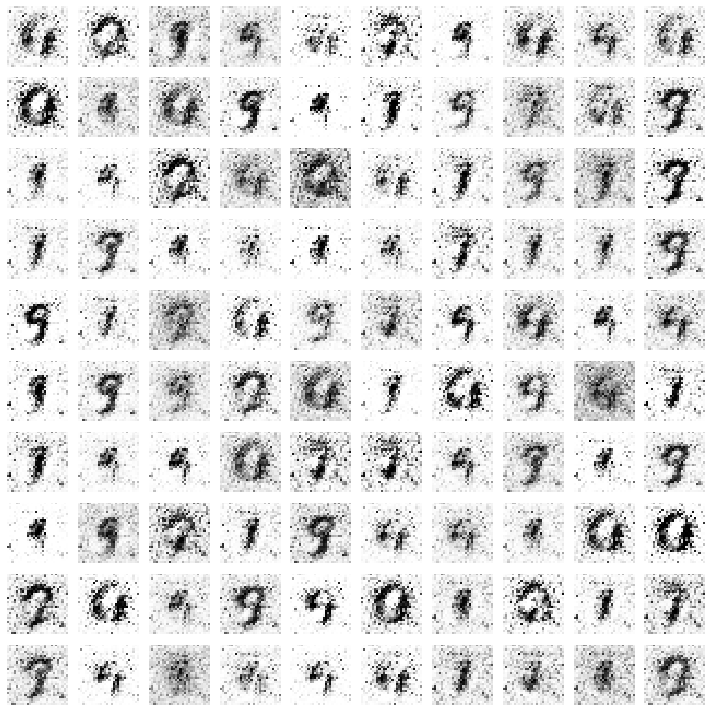

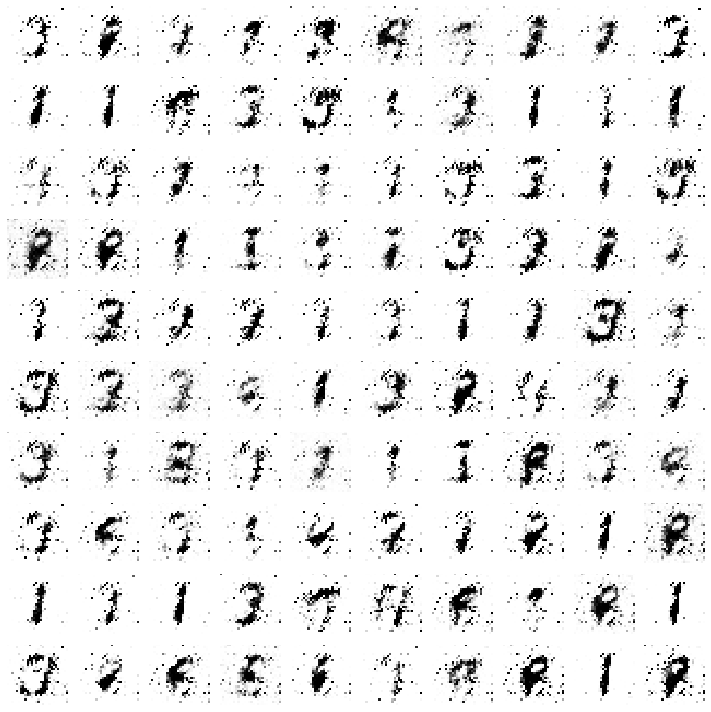

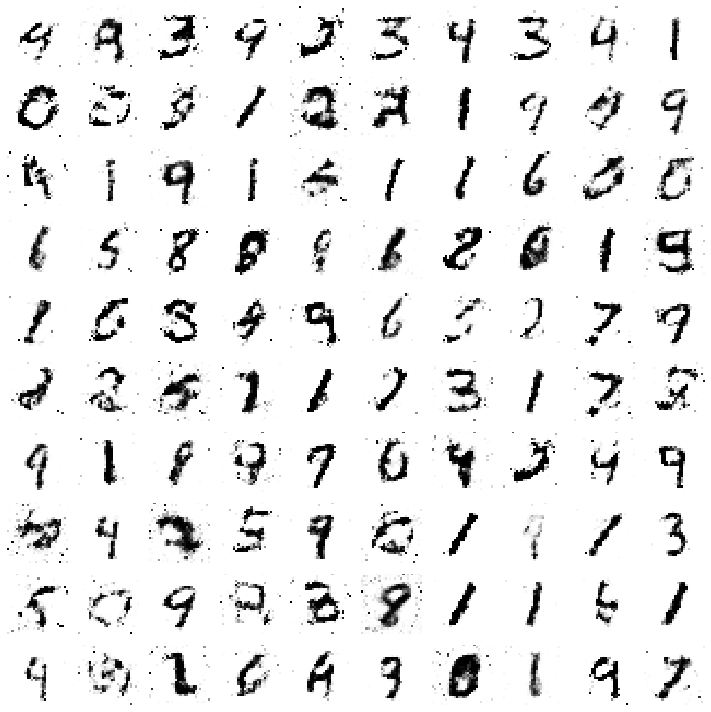

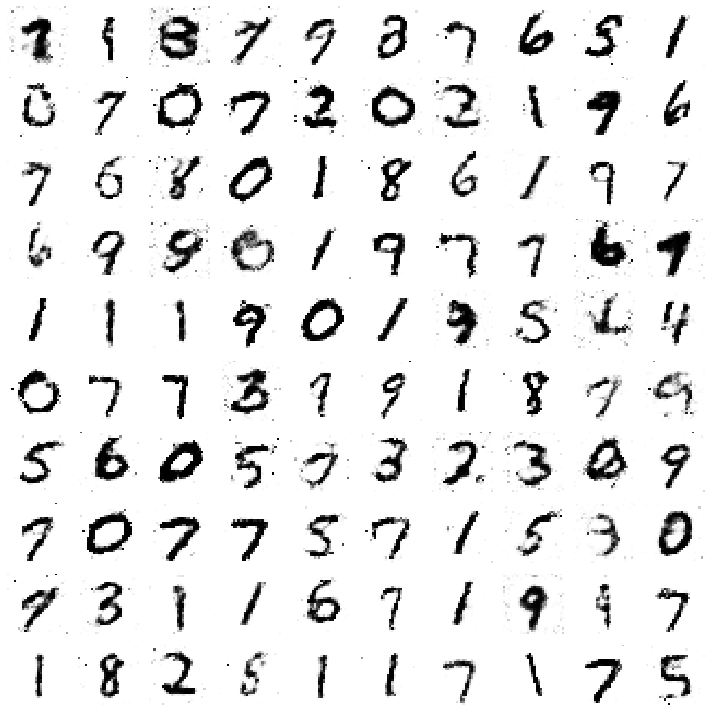

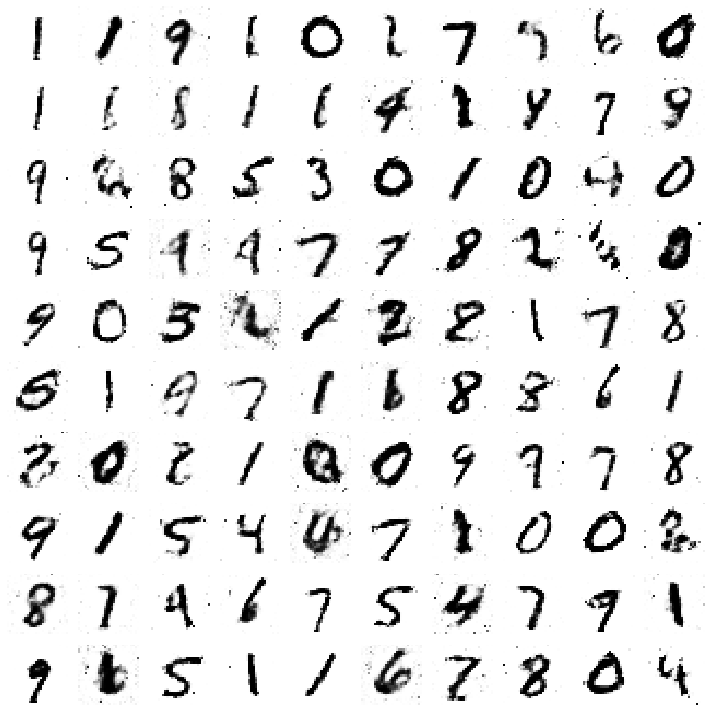

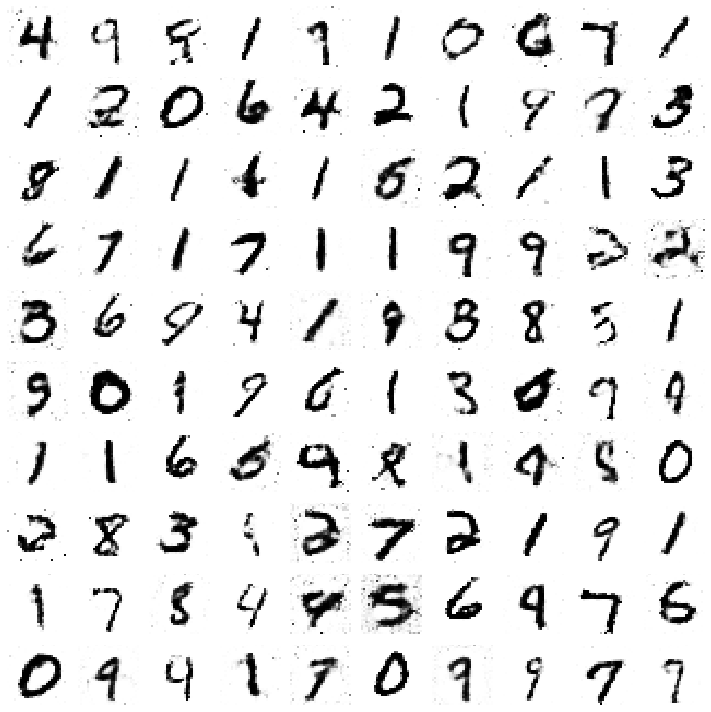

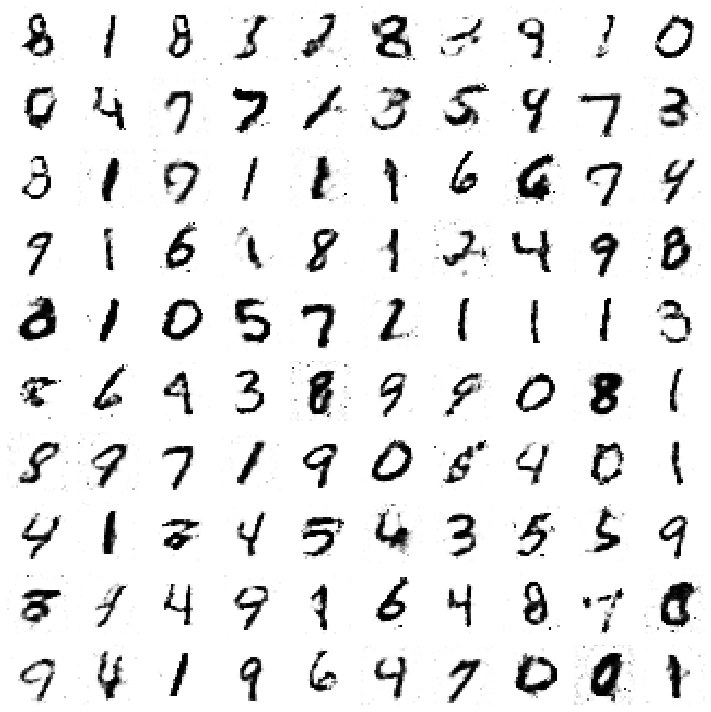

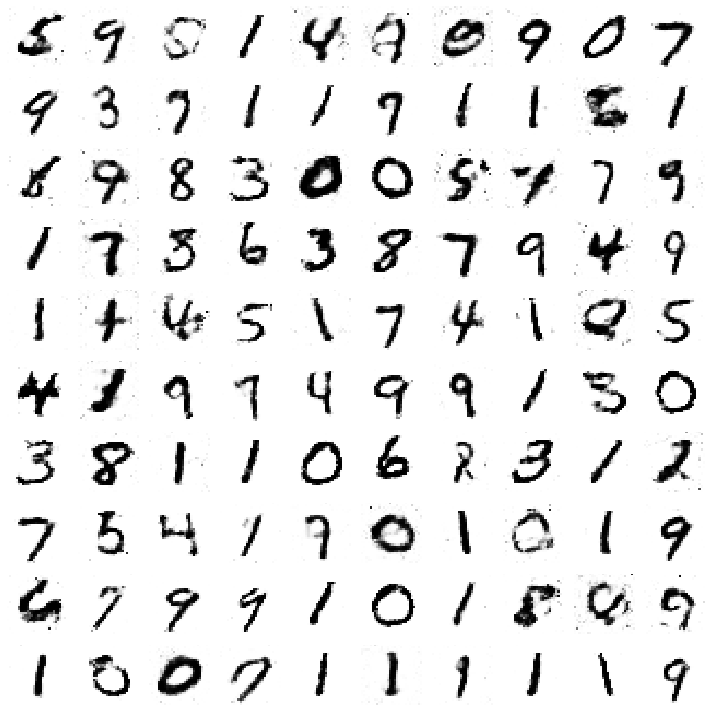

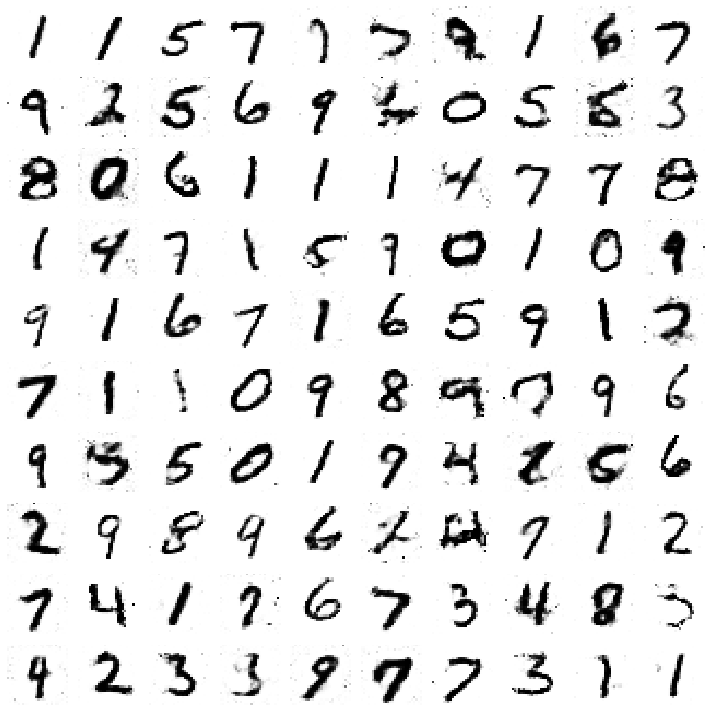

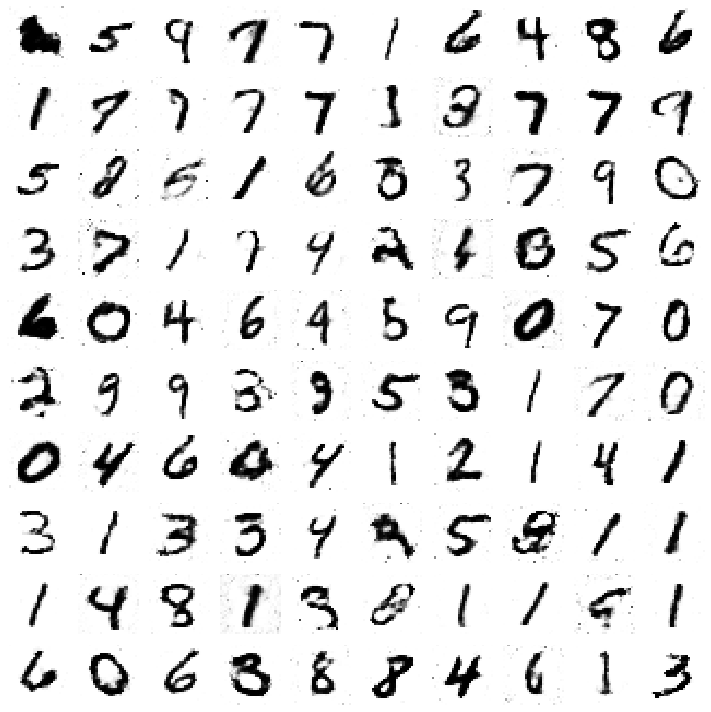

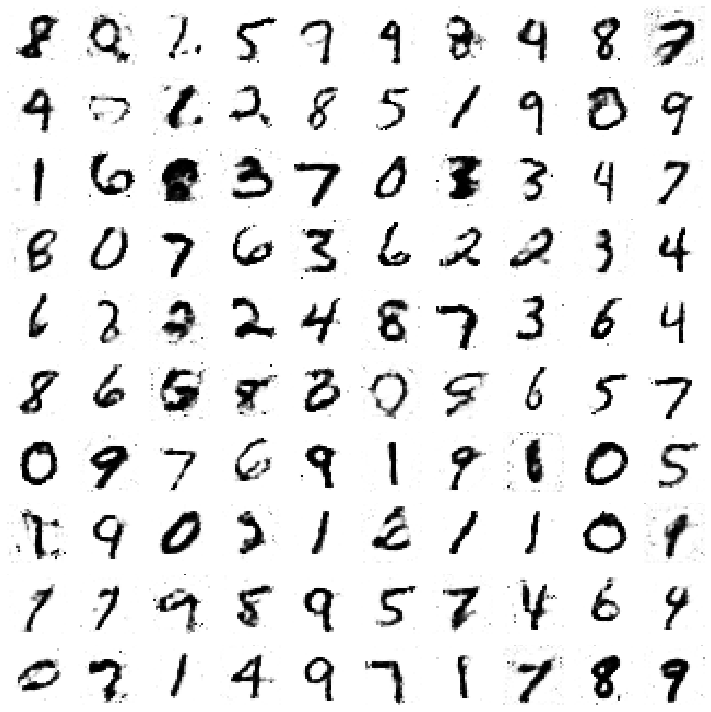

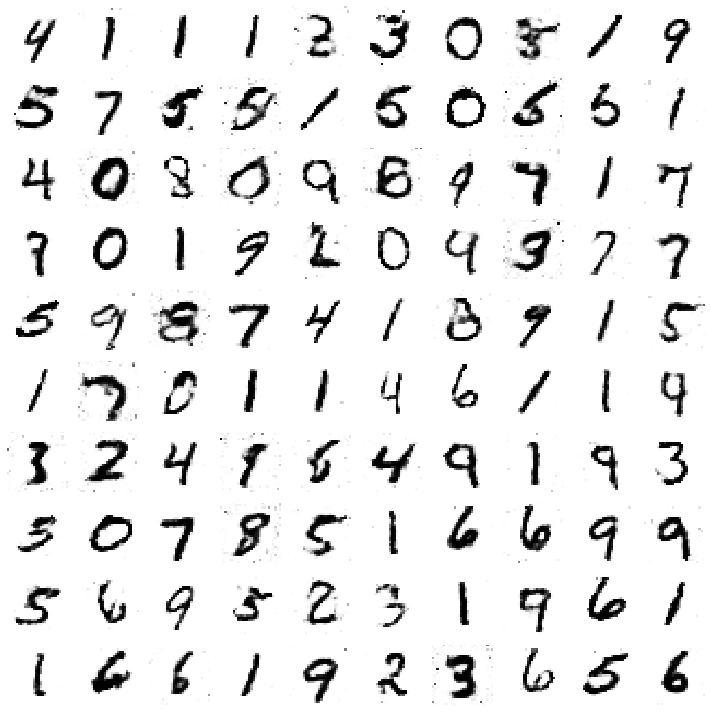

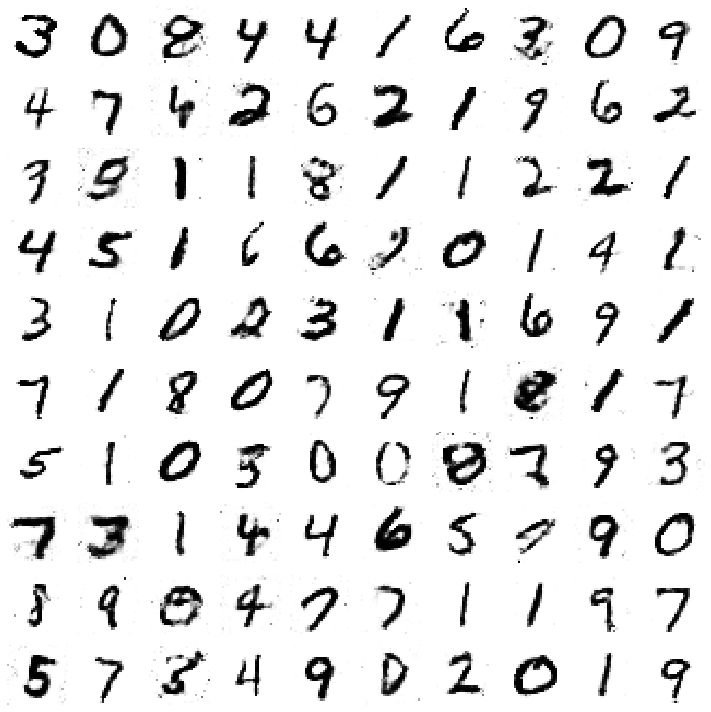

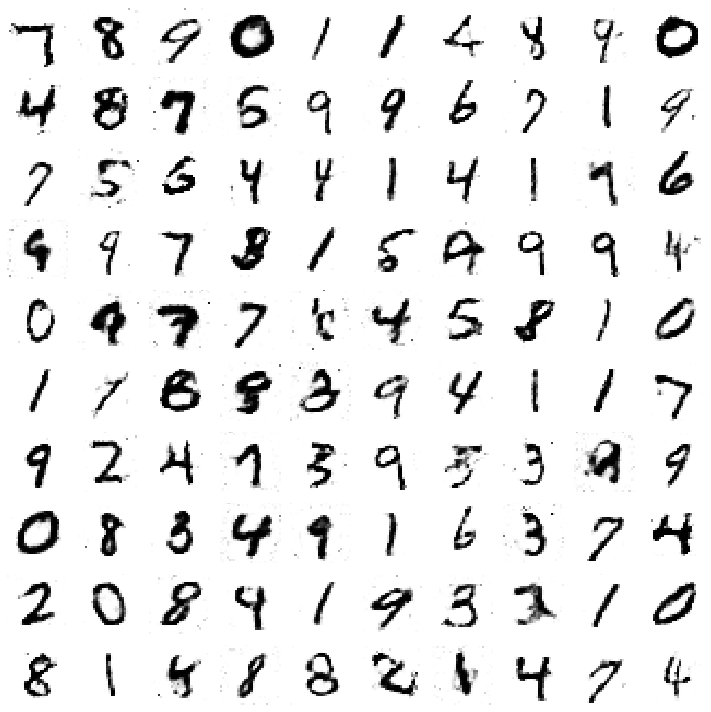

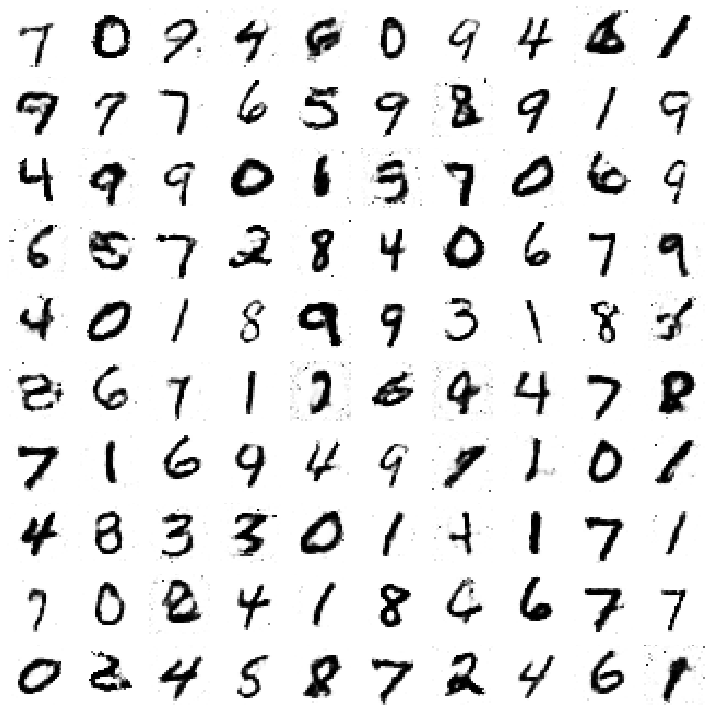

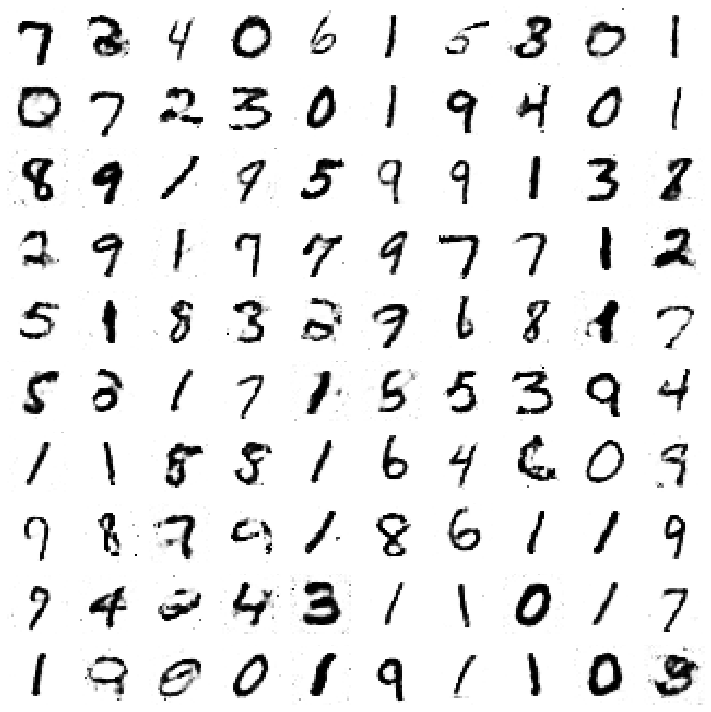

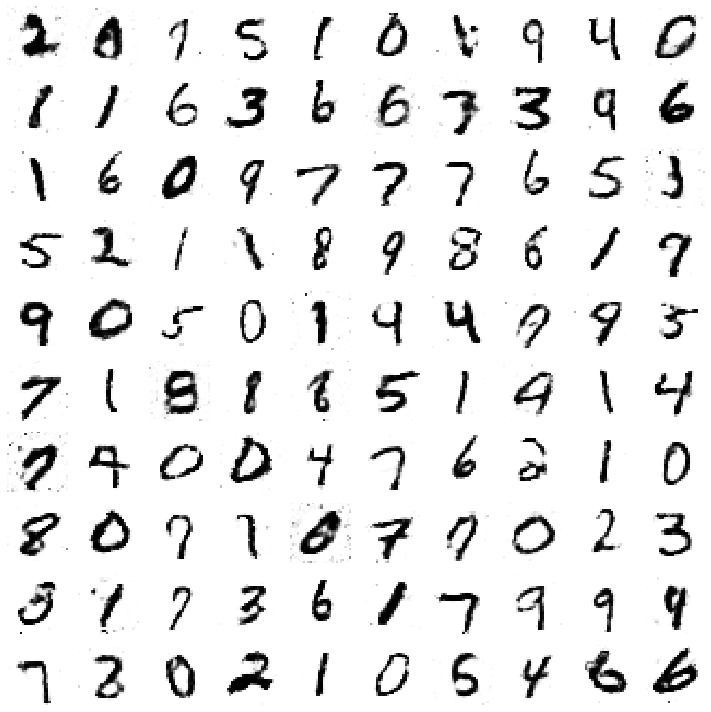

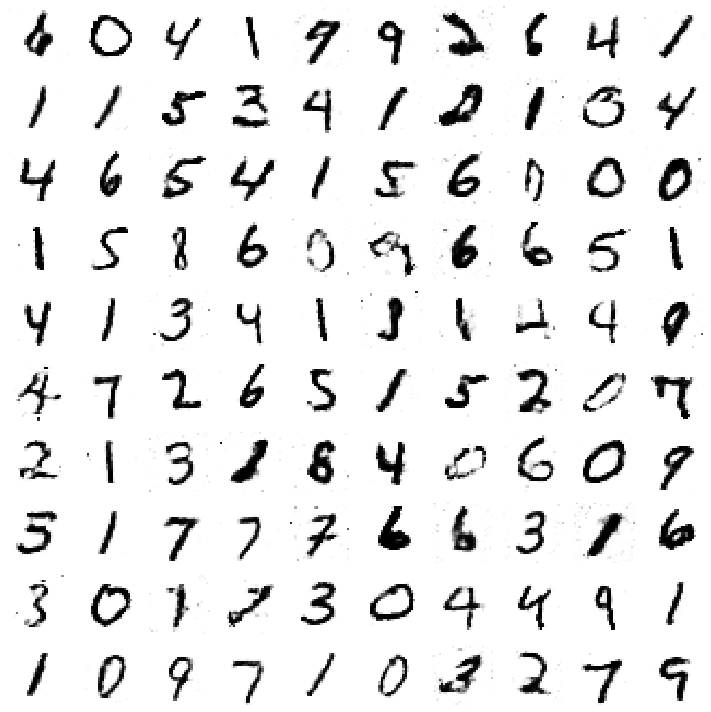

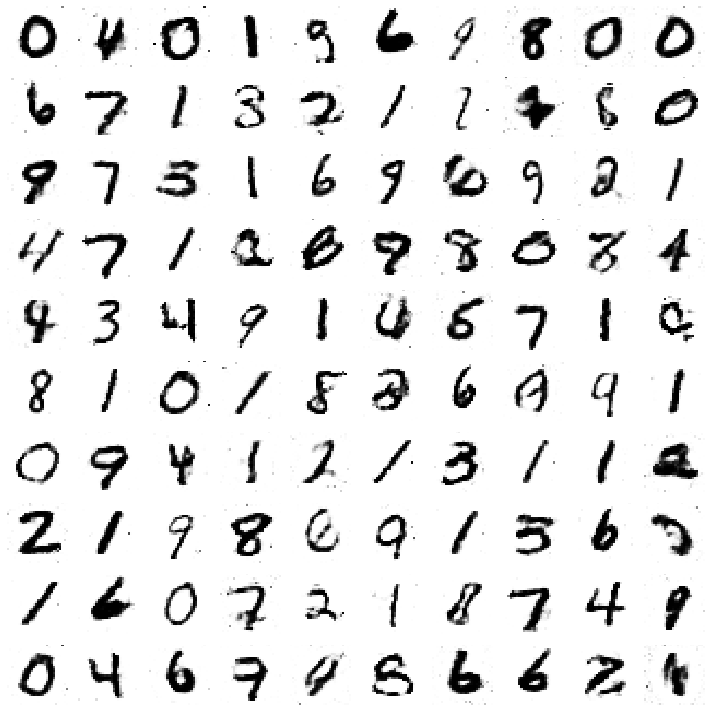

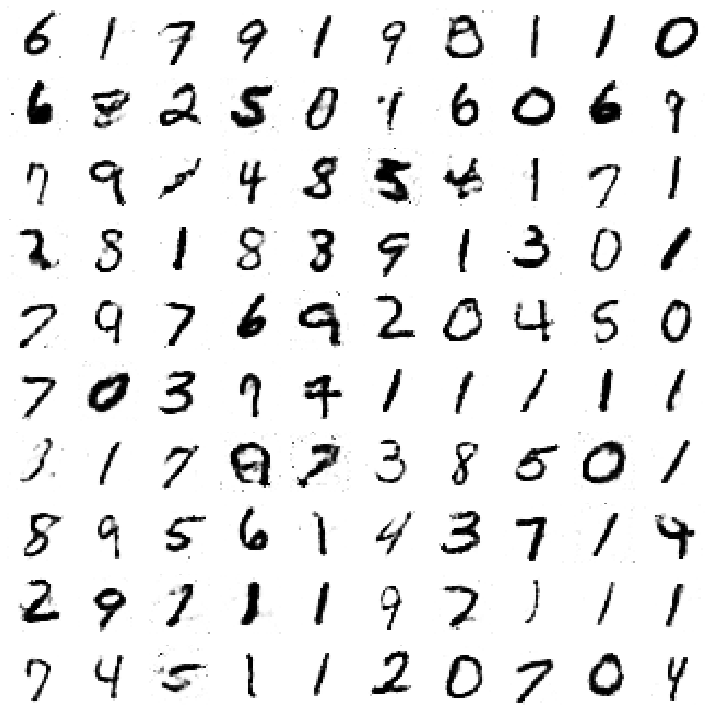

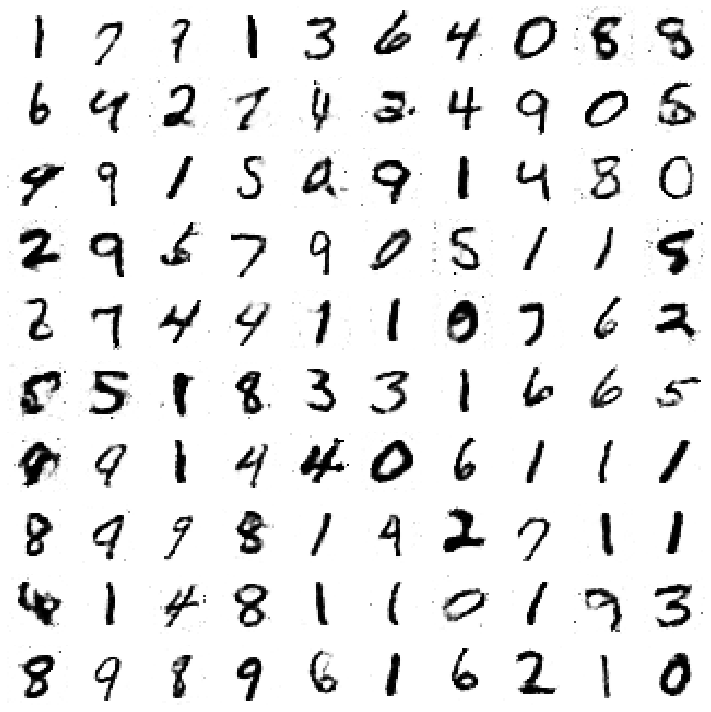

In [14]:
if __name__ == '__main__':
    train(400, 128)